<a name="top" id="top"></a>

<div align="center">
    <h1>Entropy Computing via QCi</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://github.com/murraybj">Benjamin J. L. Murray</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Undergraduate Research Assistant</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/JuliaQUBO/QUBONotebooks/blob/main/notebooks_py/4-DWAVE_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

## Entropy Computing via QCi
This notebook provides an introduction to solving constrained optimization problems using **Quantum Computing Inc.'s (QCI) Entropy Quantum Computer**.
We will define a **Constrained Quadratic Model** by setting up an objective function and a series of linear constraints. The notebook demonstrates how to:
1.  Structure the problem using QCI's `eqc_models` library.
2.  Submit the model to the `Dirac3IntegerCloudSolver` and `Dirac3ContinuousSolver` for processing.
3.  Analyze the high-quality candidate solutions returned by the solver to find the optimal result.



In [1]:
# If using this on Google colab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install eqc_models

In [4]:
# Import the QCI models and solvers
import eqc_models
from eqc_models.base import ConstrainedPolynomialModel, PolynomialModel
from eqc_models.solvers import Dirac1CloudSolver, Dirac3IntegerCloudSolver, Dirac3ContinuousCloudSolver


# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
import pyomo.environ as pyo
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

In order to define the $Q$ matrix, we write the problem
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x}\\
s.t. \mathbf{A}\mathbf{x}=\mathbf{b} \\
\mathbf{x} \in \{0,1 \}^{11}
$$
as follows:
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x} + \rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
\mathbf{x} \in \{0,1 \}^{11}
$$
Exploting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $Q$ matrix.
$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}^\top (\mathbf{A}^\top \mathbf{A}) \mathbf{x} - 2\mathbf{b}^\top \mathbf{A} \mathbf{x} + \mathbf{b}^\top \mathbf{b} )
$$
For this problem in particular, one can prove the the penalization factor is given by $\rho > \sum_{i=1}^n |c_i|$, therefore we choose this bound + 1.

## Now let's solve this using Dirac-3!
### Automated Problem Reformulation

The `eqc_models` library is designed to do the heavy lifting for you. It automatically handles the complex mathematical conversion of your problem into a QUBO, so you **do not need to derive the** $Q$ **matrix yourself**.

You simply need to define your problem in its original, intuitive form by providing:

* **`C`**: The cost vector for your objective function.
* **`J`**: The matrix for the quadratic part of your objective function ($\mathbf{x}^\top \mathbf{J} \mathbf{x}$). Since this specific problem is linear, it has no quadratic terms, so `J` is simply a matrix of zeros.
* **`lhs`** and **`rhs`**: The matrix and vector that define your constraints ($\mathbf{A}\mathbf{x} = \mathbf{b}$).

The `ConstrainedQuadraticModel` takes these straightforward inputs and performs the necessary reformulation internally before sending the problem to the solver.

In [ ]:
import os
import numpy as np
from eqc_models.base.quadratic import ConstrainedQuadraticModel
from eqc_models.solvers import Dirac3IntegerCloudSolver

api_url = "https://api.qci-prod.com" 
api_token = "" # Replace with your actual API token

C = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5, 6, 5], dtype=np.int64)
J = np.zeros((11, 11), dtype=np.int64)

lhs = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])

rhs = np.array([1, 1, 1], dtype=np.int64)

# Create the constrained quadratic model(objective + penalty for Ax = b)
model = ConstrainedQuadraticModel(C, J, lhs, rhs)
model.penalty_multiplier = C.sum() + 1 
model.upper_bound = np.ones(11, dtype=np.int64)

# solve via QCI cloud solver
solver = Dirac3IntegerCloudSolver(url=api_url, api_token=api_token)

response = solver.solve(model, num_samples=100)

In [66]:
for sol in response["results"]["solutions"]:
    print("x =", sol)

x = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
x = [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
x = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
x = [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
x = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
x = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
x = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


## Finding the Optimal Solution
The QCI solver returns a set of high-quality candidate solutions. This code block iterates through them to find the single best one based on our original objective function.

In [63]:
best_solution = None
min_objective_value = float('inf')

# The loop now processes the results directly from the 'response' object
for sol_list in response["results"]["solutions"]:
    # Convert solution from list to numpy array for calculations
    sol_array = np.array(sol_list)
    
    # Calculate objective value (constraints are implicitly handled by the solver's penalty)
    objective_value = np.dot(C, sol_array)
    
    # Check if this solution is the best one found so far
    if objective_value < min_objective_value:
        min_objective_value = objective_value
        best_solution = sol_array

print("--- Analysis Complete ---")
if best_solution is not None:
    print(f"The best solution found is: {best_solution}")
    print(f"Its objective value is: {min_objective_value}")
else:
    print("No solutions were returned by the solver.")

--- Analysis Complete ---
The best solution found is: [0 0 0 0 0 0 0 0 1 0 0]
Its objective value is: 5


Minimum Objective Value: 5
Best Solution Found: 00000000100


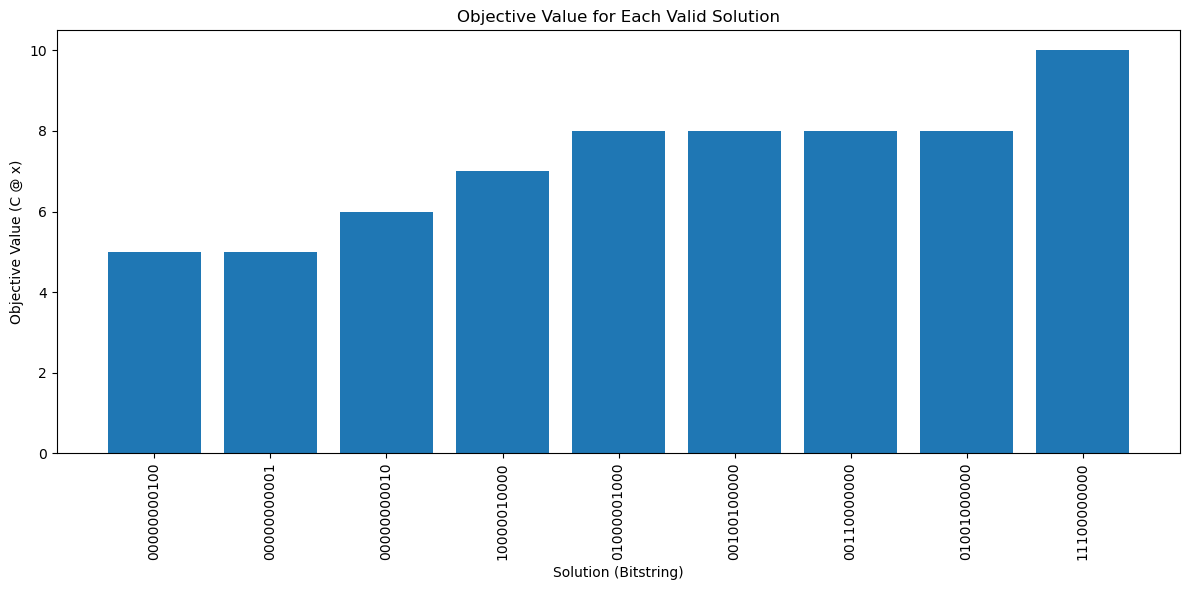

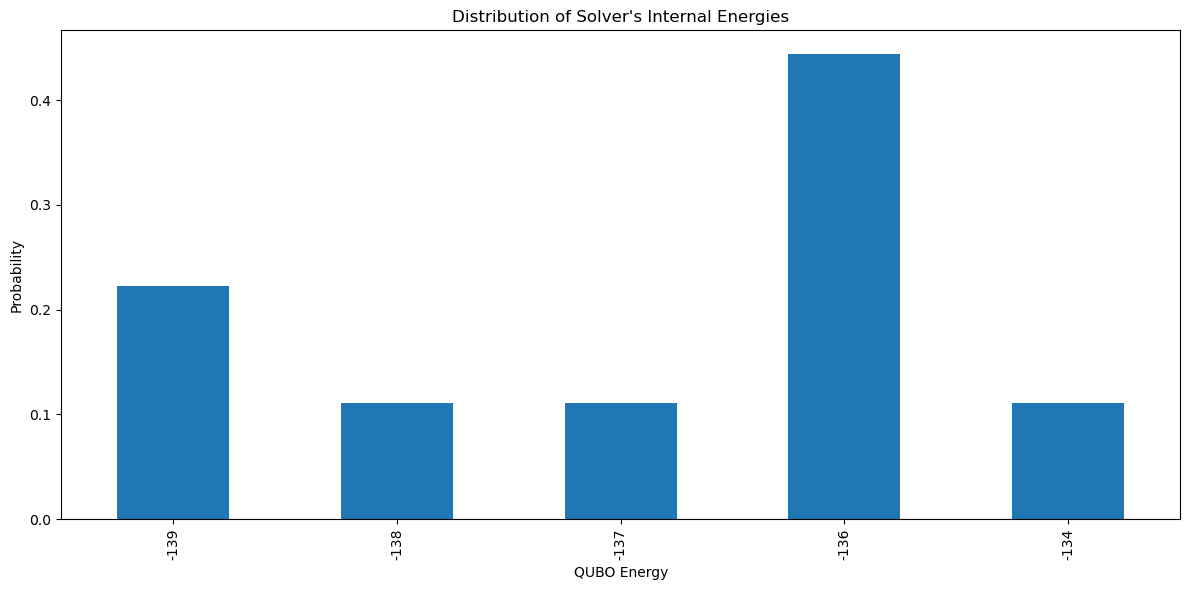

Minimum QUBO Energy: -139


In [65]:
def plot_objective_values(response, C, title="Solution Objective Values"):
    """
    Plots the true objective value for each unique solution returned by the QCI solver.

    This is more meaningful than plotting the QUBO "energy," as it shows the
    quality of each solution with respect to the original problem definition.

    Args:
        response (dict): The response object from the QCI solver.
        C (np.array): The original cost vector of the objective function.
        title (str): The title for the plot.
    """
    # Extract the list of unique solutions
    solutions = response["results"]["solutions"]
    if not solutions:
        print("No solutions found in the response.")
        return

    # Calculate the true objective value for each solution
    objective_values = [np.dot(C, s) for s in solutions]
    
    # Create string representations of the binary solutions for labels
    solution_strings = [''.join(map(str, s)) for s in solutions]

    # Find the minimum objective value and the corresponding best solution
    min_value = min(objective_values)
    best_solution_str = solution_strings[objective_values.index(min_value)]

    print(f"Minimum Objective Value: {min_value}")
    print(f"Best Solution Found: {best_solution_str}")

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.bar(solution_strings, objective_values)
    plt.xlabel('Solution (Bitstring)')
    plt.ylabel('Objective Value (C @ x)')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def plot_energy_distribution(response, title="QUBO Energy Distribution"):
    """
    Plots the distribution of the raw QUBO energies from the solver.

    This shows the probability of measuring each energy state and is useful
    for diagnosing the solver's performance on the underlying QUBO formulation.

    Args:
        response (dict): The response object from the QCI solver.
        title (str): The title for the plot.
    """
    # Extract energies from the response
    energies = response["results"].get("energies")
    
    if not energies:
        print("No energy data found in the response.")
        return

    # The total number of samples is the length of the energies list
    total_samples = len(energies)
    
    # Use collections.Counter to get the occurrences of each energy value.
    # We round the energies to group very similar floating-point values.
    energy_counts = Counter(round(e, 5) for e in energies)
    
    # Calculate the probability for each unique energy level
    energy_probabilities = {energy: count / total_samples for energy, count in energy_counts.items()}
        
    # Create a pandas DataFrame for easy plotting
    df = pd.DataFrame.from_dict(energy_probabilities, orient='index', columns=['Probability']).sort_index()

    # Create the plot
    df.plot(kind='bar', legend=None, figsize=(12, 6))
    plt.xlabel('QUBO Energy')
    plt.ylabel('Probability')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    print(f"Minimum QUBO Energy: {min(energies)}")


# --- Example Usage ---
# After you have run your solver and have the 'response' object:

# 1. Plot the true objective values for each solution
plot_objective_values(response, C, title="Objective Value for Each Valid Solution")

# 2. Plot the distribution of the internal QUBO energies
plot_energy_distribution(response, title="Distribution of Solver's Internal Energies")

### Solving Problems using Dirac-3

Dirac-3 can solve combinatorial optimization problems using the follwing objective function, `E`, that has the following high-order polynomial structure:

\begin{equation*}
E = \sum_{i=1}^{N} C_i V_i + \sum_{i,j=1}^{N,N} J_{ij} V_i V_j + \sum_{i,j,k=1}^{N,N,N} T_{ijk} V_i V_j V_k + \sum_{i,j,k,l=1}^{N,N,N,N} Q_{ijkl} V_i V_j V_k V_l + \sum_{i,j,k,l,m=1}^{N,N,N,N,N} P_{ijklm} V_i V_j V_k V_l V_m 
\end{equation*}

$V_i$ refers to the value of nonnegative variable, and $C_i$, $J_{ij}$, $T_{ijk}$, $Q_{ijkl}$, and $P_{ijklm}$ are the coefficients of the objective function.
The solver defaults to minimization. 
To solve a maximization problem, you should multiply the entire objective function by -1.

### Continuous Solver

The Dirac-3 continuous solver is particularly well-suited for this objective function, treating it as a **quasi-continuous optimization problem**.
In this approach, the solver operates under the linear constraint

\begin{equation*}
R = \sum_{i=1}^{N} V_i, \quad R \in [1, 10000].
\end{equation*}

Note that $R$ is a fixed value, which for this problem must be in the range of [1, 10000].

Let's try to solve the following simple quadratic problem with linear constraints using the Dirac-3 continuous solver:

\begin{align*}
\min \quad & E = 3 x_1^2 + 2 x_2^2 + x_3^2 \\
\text{s.t.} \quad & x_1 + x_2 + x_3 = 10, \\
& x_1, x_2, x_3 \in [0, 10].
\end{align*}

In [7]:
# 1. Create a concrete Pyomo model
m = pyo.ConcreteModel(name="Simple_Quadratic_Program")

# 2. Define the decision variables with their bounds
# The variables x_1, x_2, and x_3 are defined with bounds [0, 10].
m.x = pyo.Var([1, 2, 3], domain=pyo.NonNegativeReals, bounds=(0, 10))

# 3. Define the objective function
# The objective is to minimize the quadratic expression.
m.obj = pyo.Objective(
    expr=3*m.x[1]**2 + 2*m.x[2]**2 + m.x[3]**2, 
    sense=pyo.minimize
)

# 4. Define the linear constraint
# The sum of the variables must equal 10.
m.c1 = pyo.Constraint(expr=m.x[1] + m.x[2] + m.x[3] == 10)

# 5. Create a solver instance and solve the model
# We specify 'scip' as the solver. 'tee=True' displays the solver's log.
solver = pyo.SolverFactory('scip')
results = solver.solve(m, tee=False)

# 6. Display the optimization results
print("\n" + "="*30)
print("-- 📊 Optimization Results --")
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}")
print(f"Objective Value (E): {pyo.value(m.obj):.4f}")
print("\n-- 🏗️ Variable Values --")
for i in m.x:
    print(f"x[{i}] = {pyo.value(m.x[i]):.4f}")
print("="*30)


-- 📊 Optimization Results --
Solver Status: ok
Termination Condition: optimal
Objective Value (E): 54.5455

-- 🏗️ Variable Values --
x[1] = 1.8183
x[2] = 2.7272
x[3] = 5.4545


#### Now let's solve this problem using the Dirac-3 continuous solver.
#### 1. Defining the Objective Function

The polynomial objective function, `E`, is defined by combining two lists: `coefficients` and `indices`.

* `coefficients`: This list contains the numerical multiplier for each term in your objective function.

    ```python
    coefficients = [3, 2, 1] 
    ```

* `indices`: This list of tuples specifies which variables are multiplied together for each term. The numbers in the tuples correspond to the variable indices (e.g., `1` for $x_1$, `2` for $x_2$).

    ```python
    # (1,1) -> x_1*x_1  |  (2,2) -> x_2*x_2  |  (3,3) -> x_3*x_3
    indices = [(1,1), (2,2), (3,3)]
    ```

The `PolynomialModel` maps the `coefficients` to the `indices` in order, creating the full objective function:

$E = \underbrace{3}_{\text{coef[0]}} \cdot \underbrace{x_1 x_1}_{\text{idx[0]}} + \underbrace{2}_{\text{coef[1]}} \cdot \underbrace{x_2 x_2}_{\text{idx[1]}} + \underbrace{1}_{\text{coef[2]}} \cdot \underbrace{x_3 x_3}_{\text{idx[2]}}$

### 2. Setting Constraints

Constraints are handled in two different places:

* **Variable Bounds** `upper_bound`: The individual upper bounds for each variable are set as an attribute on the `model` object *after* it has been created.

    ```python
    # Sets the upper bound for all 3 variables to 10
    model.upper_bound = 10 * np.ones((3,))
    ```

In [ ]:
R = 10
coefficients = [3, 2, 1]
indices = [(1,1), (2,2), (3,3)] # Create a polynomial model
model = PolynomialModel(coefficients, indices)
model.upper_bound = R*np.ones((3,)) # Bounds for the variables

#### 3. Submitting the Model to the Solver
When submitting the model to the solver, you need to provide several key parameters:

* `sum_constraint`: The constraint on the sum of all variables ($R = \sum V_i$) is a **required input** for the `solver.solve()` method.
* `relaxation_schedule`: An integer from the set `{1, 2, 3, 4}` representing one of four predefined schedules. Higher values reduce variation in the analog spin values during the solving process and are more likely to result in a better objective function value.
* `num_samples`: An integer specifying the number of independent solutions (samples) to be generated by the device.

```python
# The solver needs the value for R, the schedule, and number of samples
response = solver.solve(
    model, 
    sum_constraint=10, 
    relaxation_schedule=1, 
    num_samples=10
)

In [ ]:
api_url = "https://api.qci-prod.com" 
api_token = "842e30fa37ef03f311bf3dc48f0ea3e5" # Replace with your actual API token

solver = Dirac3ContinuousCloudSolver(url=api_url, api_token=api_token)
response = solver.solve(model, sum_constraint=10, relaxation_schedule=1, num_samples=20) # sum constraint is set to 10, 5 samples are collected

# Print the results
print(response["results"]["solutions"])
print(response["results"]["energies"])
print(response["results"]["counts"])

2025-07-11 14:55:25 - Dirac allocation balance = 9645 s (unmetered)
2025-07-11 14:55:25 - Job submitted: job_id='68715e1d32604586ad908498'
2025-07-11 14:55:25 - QUEUED
2025-07-11 14:55:28 - RUNNING
2025-07-11 14:55:30 - COMPLETED
2025-07-11 14:55:33 - Dirac allocation balance = 9645 s (unmetered)
{'job_info': {'job_id': '68715e1d32604586ad908498', 'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '68715e1cacc178773e9924d9'}}, 'device_config': {'dirac-3_normalized_qudit': {'num_samples': 20, 'relaxation_schedule': 1, 'sum_constraint': 10}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-07-11T18:55:25.212Z', 'queued_at_rfc3339nano': '2025-07-11T18:55:25.213Z', 'running_at_rfc3339nano': '2025-07-11T18:55:25.444Z', 'completed_at_rfc3339nano': '2025-07-11T18:55:28.445Z'}, 'job_result': {'file_id': '68715e20acc178773e9924db', 'device_usage_s': 2}}, 'status': 'COMPLETED', 'results': {'counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

#### 4. Interpreting the Results
The solver returns a dictionary containing job information and results. The optimal solution is found by identifying the result with the lowest "energy" (objective function value).
The `response['results']` key contains three important lists that correspond to each other by index:

* `solutions`: A list of all potential solutions. Each item is a list of variable values (e.g., `[x1, x2, x3]`).

* `energies`: A list of the objective function values (`energies`) for each corresponding solution.

* `counts`: A list of how many times each solution was found (typically 1 for unique solutions).

In [9]:
# Extract the results from the response
results = response["results"]
energies = results["energies"]
solutions = results["solutions"]

# Find the index of the best solution (minimum energy)
best_index = np.argmin(energies)

# Get the best solution and its energy
best_energy = energies[best_index]
best_solution = solutions[best_index]

# Print the results in a clear format
print("-- 📊 Best Solution Found --")
print(f"Optimal Objective (Energy): {best_energy:.4f}")
print(f"Variable Values: {np.round(best_solution, 4)}")


-- 📊 Best Solution Found --
Optimal Objective (Energy): 54.5475
Variable Values: [1.808  2.7068 5.4851]


### Integer Solver
The Dirac-3 can solver unconstrained optimization problem. 
In this mode, the resulting state vector $V_i$ consists of integers:

\begin{equation*}
V_i \in \mathbb{N}, \quad 0 \leq V_i \leq 16
\end{equation*}

For integer problems, you must define the number of possible states (or levels) for each variable. 
For instance, to model a standard Qudratic Unconstrained Binary Optimization problem, you would set the number of levels for each variable to 2. 
This restricts the variables to two possible states, 0 and 1, which is equivalent to defining a binary variable with an upper bound of 1.

The solver is flexible, allowing for mixed encoding where some variables have 2 levels (binary) while others have more (up to 17 levels, for an upper bound of 16). 
If your problem requires more than 17 distinct states for any variable, the **continuous solver** is the recommended approach.

Let's solve the simple QUBO problem given by the following objective function:

\begin{align*}
\min \quad & E = -0.75 x_1^2 - 0.25 x_2^2 + 2 x_1 x_2 + 0.5 x_1 \\
\text{s.t.} \quad & x_1, x_2 \in \{0,1\} \\
\end{align*}

In [18]:
# 1. Create a concrete Pyomo model
m = pyo.ConcreteModel(name="Simple_QUBO")

# 2. Define the binary variables
# x[1] and x[2] can only take values of 0 or 1.
m.x = pyo.Var([1, 2], domain=pyo.Binary)

# 3. Define the objective function
# We use the property that for a binary variable x, x^2 = x.
# So, the objective E = -0.75*x1^2 - 0.25*x2^2 + 2*x1*x2 + 0.5*x1 becomes:
# E = -0.75*x1 - 0.25*x2 + 2*x1*x2
m.obj = pyo.Objective(
    expr= -0.75 * m.x[1] - 0.25 * m.x[2] + 2 * m.x[1] * m.x[2] + 0.5 * m.x[1],
    sense=pyo.minimize
)

# 4. Create a solver instance and solve the model
# This is an unconstrained problem, so no constraints are needed.
# We use a Mixed-Integer Programming (MIP) solver like 'scip'.
solver = pyo.SolverFactory('scip')
results = solver.solve(m, tee=False)

# 5. Display the optimization results
print("\n" + "="*30)
print("-- 📊 Optimization Results --")
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}")
print(f"Objective Value: {pyo.value(m.obj):.4f}")
print("\n-- 🏗️ Variable Values --")
for i in m.x:
    print(f"x[{i}] = {int(pyo.value(m.x[i]))}")
print("="*30)


-- 📊 Optimization Results --
Solver Status: ok
Termination Condition: optimal
Objective Value: -0.2500

-- 🏗️ Variable Values --
x[1] = 1
x[2] = 0


#### Now let's solve this problem using the Dirac-3 Integer solver.
The problem's `coefficients` and `indices` are structured in the same way as they were for the continuous solver.

In [35]:
coefficients = [-0.75, -0.25, 2, 0.5]  # Coefficients for the polynomial model
indices = [(1, 1), (2, 2), (1, 2), (0, 1)]  # Create a polynomial model
model = PolynomialModel(coefficients, indices)

# add upper bounds for the variables
model.upper_bound = np.ones((2,))  # Bounds for the variables

For integer and binary optimization problems, the sum_constraint is not necessary because `Dirac3IntegerCloudSover` operates in an unconstrained mode.

In [37]:
solver = Dirac3IntegerCloudSolver(url=api_url, api_token=api_token)
response = solver.solve(model, relaxation_schedule=1, num_samples=10)

# Print the results
print(response)
print(response["results"]["solutions"])
print(response["results"]["energies"])
print(response["results"]["counts"])

2025-07-11 17:10:13 - Dirac allocation balance = 9645 s (unmetered)
2025-07-11 17:10:13 - Job submitted: job_id='68717db532604586ad9084a3'
2025-07-11 17:10:13 - QUEUED
2025-07-11 17:10:16 - RUNNING
2025-07-11 17:10:23 - COMPLETED
2025-07-11 17:10:26 - Dirac allocation balance = 9645 s (unmetered)
{'job_info': {'job_id': '68717db532604586ad9084a3', 'job_submission': {'problem_config': {'qudit_hamiltonian_optimization': {'polynomial_file_id': '68717db4acc178773e992517'}}, 'device_config': {'dirac-3_qudit': {'num_levels': [2, 2], 'num_samples': 10, 'relaxation_schedule': 1}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-07-11T21:10:13.137Z', 'queued_at_rfc3339nano': '2025-07-11T21:10:13.138Z', 'running_at_rfc3339nano': '2025-07-11T21:10:13.64Z', 'completed_at_rfc3339nano': '2025-07-11T21:10:21.114Z'}, 'job_result': {'file_id': '68717dbdacc178773e992519', 'device_usage_s': 4}}, 'status': 'COMPLETED', 'results': {'counts': [8, 2], 'energies': [-0.25, -0.25], 'solutions': [[0, 1], [1, 0

This code processes the solver's results by counting the frequency of each unique solution and then uses `matplotlib` to create a bar chart visualizing this distribution.

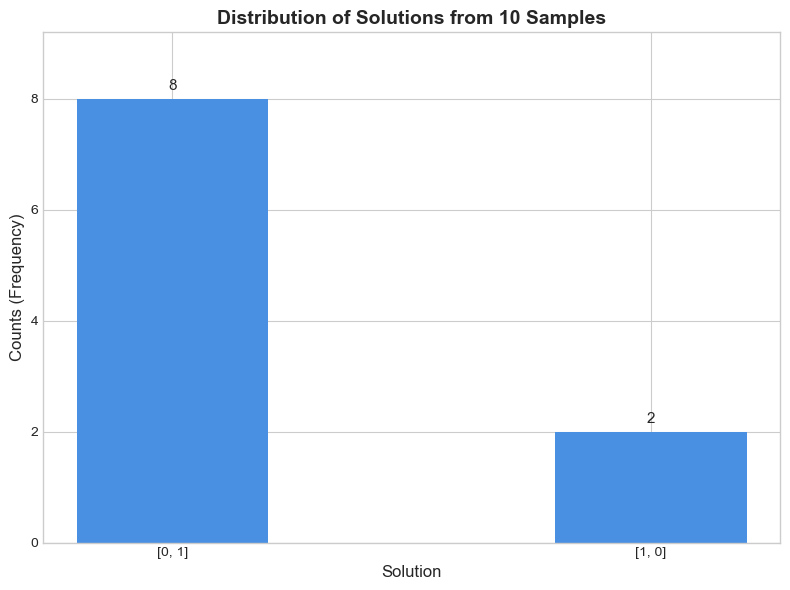

In [38]:
# --- Data Processing ---
# Extract the raw results
raw_solutions = response['results']['solutions']
raw_counts = response['results']['counts']

# Aggregate counts for each unique solution
solution_counts = {}
for solution, count in zip(raw_solutions, raw_counts):
    # Convert list to tuple to use as a dictionary key
    solution_tuple = tuple(solution)
    solution_counts[solution_tuple] = solution_counts.get(solution_tuple, 0) + count

# Prepare data for plotting
# Create string labels for the x-axis from the solution tuples
plot_solutions_str = [str(list(s)) for s in solution_counts.keys()]
plot_counts = list(solution_counts.values())

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

# Create the bar plot
bars = ax.bar(plot_solutions_str, plot_counts, color='#4A90E2', width=0.4)

# Add labels and title for clarity
ax.set_xlabel("Solution", fontsize=12)
ax.set_ylabel("Counts (Frequency)", fontsize=12)
ax.set_title("Distribution of Solutions from 10 Samples", fontsize=14, fontweight='bold')

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, int(yval), ha='center', va='bottom', fontsize=11)

# Set y-axis to start at 0
ax.set_ylim(0, max(plot_counts) * 1.15)

# Show the plot
plt.tight_layout()
plt.show()

#### Solving Quadratic Unconstrained Binary Optimization (QUBO) Problems via Dirac-3 Integer Solver
We define a QUBO as the following optimization problem:
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.

#### Example
Suppose we want to solve the following linear integer problem via QUBO
$$
\min_{\mathbf{x}} 2𝑥_0+4𝑥_1+4𝑥_2+4𝑥_3+4𝑥_4+4𝑥_5+5𝑥_6+4𝑥_7+5𝑥_8+6𝑥_9+5𝑥_{10} \\
s.t. \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
\mathbf{x} \in \{0,1 \}^{11}
$$


First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective. Let's first define the problem parameters

In [40]:
A = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])
b = np.array([1, 1, 1])
c = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5, 6, 5])
num_variables = A.shape[1]

Given the parameters, we can solve the problem using classical methods.
However, we can also use the `eqc_models` library to solve this problem using the Dirac-3 Integer solver.

In [43]:
# Build a Pyomo model for the constrained linear integer program
m = pyo.ConcreteModel(name="Constrained_Linear_Integer_Program")

# Define the set of variable indices
m.I = pyo.RangeSet(0, num_variables - 1)
# Define the set of constraint indices
m.J = pyo.RangeSet(0, A.shape[0] - 1)

# Define the 11 binary variables
m.x = pyo.Var(m.I, domain=pyo.Binary)

# Define the Objective Function
# The objective is the original linear expression.
m.obj = pyo.Objective(
    expr=sum(c[i] * m.x[i] for i in m.I),
    sense=pyo.minimize
)

# Define the constraints
# We define a set of constraints Ax = b directly.
def ax_constraint_rule(model, j):
    # For each row j, sum(A[j,i] * x[i]) must equal b[j]
    return sum(A[j, i] * model.x[i] for i in model.I) == b[j]

m.constraints = pyo.Constraint(m.J, rule=ax_constraint_rule)

# Solve the model
# We use a Mixed-Integer Linear Programming (MILP) solver.
solver = pyo.SolverFactory('scip')
results = solver.solve(m, tee=False)

# Display the optimization results
print("\n" + "="*40)
print("-- 📊 Optimization Results --")
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}")
print(f"Objective Value: {pyo.value(m.obj):.4f}")

print("\n-- 🏗️ Variable Values --")
solution_vector = [int(pyo.value(m.x[i])) for i in m.I]
print(f"x = {solution_vector}")



-- 📊 Optimization Results --
Solver Status: ok
Termination Condition: optimal
Objective Value: 5.0000

-- 🏗️ Variable Values --
x = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In order to define the $Q$ matrix, we reformulate the linear problem
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x}\\
s.t. \mathbf{A}\mathbf{x}=\mathbf{b} \\
\mathbf{x} \in \{0,1 \}^{11}
$$
as follows:
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x} + \rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
\mathbf{x} \in \{0,1 \}^{11}
$$
Exploting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $Q$ matrix.
$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}^\top (\mathbf{A}^\top \mathbf{A}) \mathbf{x} - 2\mathbf{b}^\top \mathbf{A} \mathbf{x} + \mathbf{b}^\top \mathbf{b} )
$$
For this problem in particular, one can prove the the penalization factor is given by $\rho > \sum_{i=1}^n |c_i|$, therefore we choose this bound + 1.

In [ ]:
epsilon = 1 # small value to avoid division by zero
rho = np.sum(np.abs(c)) + epsilon # penalty multiplier

# Construct the quadratic Hamiltonian Q
Q = rho*np.matmul(A.T,A)
Q += np.diag(c)
Q -= rho*2*np.diag(np.matmul(b.T,A))

# Construct the linear Hamiltonian C


# Construct the offset term cQ
cQ = rho*np.matmul(b.T,b)
print("Quadratic Hamiltonian Q:")
print(Q)

print("Offset term cQ:")
print(cQ)

Quadratic Hamiltonian Q:
[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
144


We can visualize the graph that defines this instance using the Q matrix as the adjacency matrix of a graph.

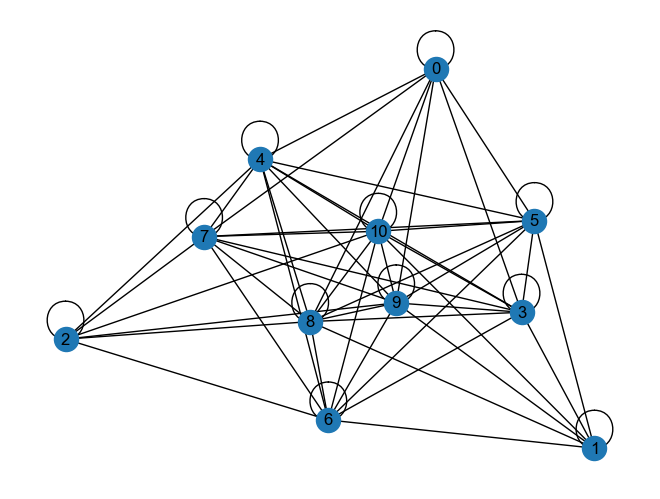

In [47]:
G = nx.from_numpy_array(Q)
nx.draw(G, with_labels=True)